In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['american_sign_language.PNG', 'sign_mnist_test.csv', 'amer_sign3.png', 'amer_sign2.png', 'sign_mnist_train.csv']


What we will do?

Data Preparation : This include 1. Loading data, Checking for null values, normalizing data, reshaping data, visualizing data and many more seps ahead.
Preparing the CNN model for sign recognizer : This include building model, optimizing model, and agumentation.
Evaluating the model
Prediction and submission
visualizing the wrong prediction

In [2]:
#importing the libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("../input/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign_mnist_test.csv")

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [5]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [7]:
print(train_df.shape)

(27455, 785)


In [8]:
print(test_df.shape)

(7172, 785)


In [9]:
label = train_df.label

In [10]:
label_test = test_df.label

In [11]:
train_df = train_df.drop("label", axis =1)
test_df = test_df.drop("label", axis = 1)
print(train_df.shape, "\n",test_df.shape)

(27455, 784) 
 (7172, 784)


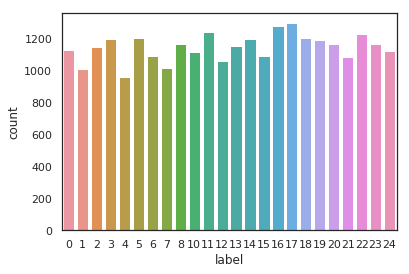

In [12]:
sns.countplot(label)

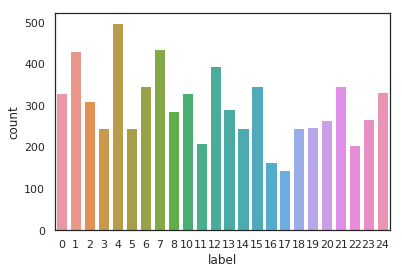

In [13]:
sns.countplot(label_test)

In [14]:
label.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [15]:
x_train = train_df.values
x_test = test_df.values
y_train = label
y_test = label_test

In [16]:
y_train.shape

(27455,)

In [17]:
x_train = x_train.reshape(x_train.shape[0], 28, 28)

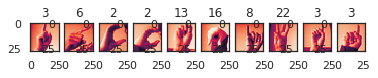

In [18]:
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])

In [19]:
x_train.shape

(27455, 28, 28)

In [20]:
y_train.shape

(27455,)

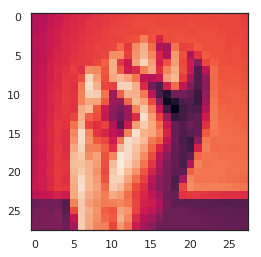

In [21]:
plt.imshow(x_train[10])

In [22]:
y_train[10]

18

In [23]:
x_train_c = x_train.reshape(x_train.shape[0], 28, 28,1)

In [24]:
x_train_c.shape

(27455, 28, 28, 1)

In [25]:
x_test_c = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [26]:
#normalizing the data
x_train_c = x_train_c/254.0
x_test_c = x_test_c/254.0

In [27]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 25)

In [28]:
y_train.shape

(27455, 25)

In [29]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
#spliting the training and test set
#set the reandom seed
SEED = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train_c, y_train, test_size = 0.1, random_state=SEED)

In [31]:
y_train.shape

(27455, 25)

21


Text(0.5, 1.0, '21')

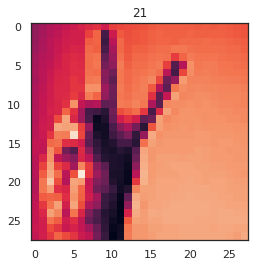

In [32]:
plt.imshow(X_train[0][:, :, 0])
for i in range(25):
    if Y_train[0, i] == 1:
        y = i
        print(y)
plt.title(y)

In [33]:
#building the cnn model
model = Sequential()
#adding 2 convolution layer followed by pooling layer and dropout layer 
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = "same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = "same", activation = "relu", ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
#adding 2 convolution layer followed by pooling layer and dropout layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',  activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',  activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), ))
model.add(Dropout(0.25))

In [35]:
#adding a flattning layer and followed by ANN neural layer
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(25, activation = "softmax"))

In [36]:
#adding the optimizer, I here used msprop but we can use adam or sgd also. But I find rms prop useful as it faster than sgd 
#better than adam
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [37]:
from keras.optimizers import SGD, Adam
optimizer_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
optimizer_2 = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

In [38]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=[ "accuracy"])

In [39]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [40]:
epochs = 30 
batch_size = 64

In [41]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [42]:
# Fit the model
classifier = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
386/386 [==============================] - 12s 30ms/step - loss: 2.6325 - acc: 0.1995 - val_loss: 1.0290 - val_acc: 0.6613
Epoch 2/30
386/386 [==============================] - 6s 16ms/step - loss: 1.3607 - acc: 0.5620 - val_loss: 0.3756 - val_acc: 0.9101
Epoch 3/30
386/386 [==============================] - 7s 19ms/step - loss: 0.8652 - acc: 0.7149 - val_loss: 0.1909 - val_acc: 0.9487
Epoch 4/30
386/386 [==============================] - 7s 17ms/step - loss: 0.6212 - acc: 0.7926 - val_loss: 0.0667 - val_acc: 0.9851
Epoch 5/30
386/386 [==============================] - 6s 16ms/step - loss: 0.4934 - acc: 0.8371 - val_loss: 0.0536 - val_acc: 0.9800
Epoch 6/30
386/386 [==============================] - 6s 16ms/step - loss: 0.4196 - acc: 0.8627 - val_loss: 0.0437 - val_acc: 0.9825
Epoch 7/30
386/386 [==============================] - 6s 16ms/step - loss: 0.3591 - acc: 0.8812 - val_loss: 0.0169 - val_acc: 0.9967
Epoch 8/30
386/386 [

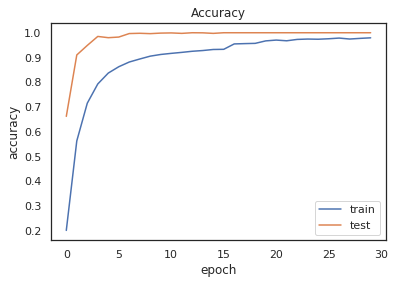

In [45]:
plt.plot(classifier.history['acc'])
plt.plot(classifier.history['val_acc'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [46]:
y_test = to_categorical(y_test, num_classes = 25)

In [47]:
y_test.shape

(7172, 25)

In [48]:
x_test_c.shape

(7172, 28, 28, 1)

In [49]:
y_pred = model.predict(x_test_c)

In [50]:
from sklearn.metrics import accuracy_score

In [52]:
y_pred[:2]

array([[3.12072541e-22, 2.81731409e-18, 1.14459283e-07, 1.41750688e-15,
        1.85075945e-16, 9.58964241e-10, 9.99999881e-01, 1.77003884e-10,
        1.14382204e-17, 0.00000000e+00, 2.00218817e-22, 1.23203610e-14,
        4.46895162e-23, 7.91499053e-25, 3.16135701e-14, 3.85277110e-23,
        2.87018582e-18, 9.78334844e-22, 7.30475848e-21, 1.48353996e-09,
        3.36627933e-26, 2.35770582e-22, 9.22344349e-22, 1.09993192e-09,
        2.42421383e-19],
       [1.69381370e-20, 5.31033171e-16, 2.39965941e-25, 1.07586767e-23,
        5.06022861e-20, 1.00000000e+00, 1.83374693e-30, 1.83520846e-31,
        3.26895027e-08, 0.00000000e+00, 8.90814445e-30, 1.57781736e-24,
        5.15475056e-31, 3.66828036e-33, 4.55395223e-29, 8.20298984e-32,
        2.50041332e-34, 2.83466514e-37, 1.96302428e-26, 3.58996170e-29,
        1.58292859e-33, 1.62103990e-20, 5.63874281e-09, 5.82009373e-26,
        3.24959248e-19]], dtype=float32)

In [53]:
accuracy_score(y_test, y_pred.round())

1.0